In [49]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from preprocessing.preprocess_data import DataSet, make_categorical, ReLU, pred_to_delivery, remap, get_constant_indices
import catboost as cb

%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)



In [50]:
         
class DataSet:
    def __init__(data_collection):
        """
        kind: observerd, estimated, train
        """

        train_a = pd.read_parquet('data/A/train_targets.parquet')
        train_b = pd.read_parquet('data/B/train_targets.parquet')
        train_c = pd.read_parquet('data/C/train_targets.parquet')

        # Estimated training data for each location
        X_train_estimated_a = pd.read_parquet('data/A/X_train_estimated.parquet')
        X_train_estimated_b = pd.read_parquet('data/B/X_train_estimated.parquet')
        X_train_estimated_c = pd.read_parquet('data/C/X_train_estimated.parquet')

        # Observed training data for each location
        X_train_observed_b = pd.read_parquet('data/B/X_train_observed.parquet')
        X_train_observed_a = pd.read_parquet('data/A/X_train_observed.parquet')
        X_train_observed_c = pd.read_parquet('data/C/X_train_observed.parquet')

        # Estimated test data for each location
        X_test_estimated_b = pd.read_parquet('data/B/X_test_estimated.parquet')
        X_test_estimated_a = pd.read_parquet('data/A/X_test_estimated.parquet')
        X_test_estimated_c = pd.read_parquet('data/C/X_test_estimated.parquet')

        Y_train = {
            'a': train_a, 
            'b':train_b, 
            'c':train_c
        }
        X_train_estimated = {
            'a':X_train_estimated_a,
            'b':X_train_estimated_b,
            'c':X_train_estimated_c
        }
        X_train_observed = {
            'a':X_train_observed_a,
            'b':X_train_observed_b,
            'c':X_train_observed_c
        }
        X_test_estimated = {
            'a':X_test_estimated_a,
            'b':X_test_estimated_b,
            'c':X_test_estimated_c
        }
        data_collection.X_train_observed =  X_train_observed
        data_collection.X_train_estimated = X_train_estimated
        data_collection.X_test_estimated = X_test_estimated
        data_collection.Y_train = Y_train

    def resample_to_hourly(data_collection):
        for loc in ['a','b','c']:
            data_collection.X_train_observed[loc] = to_hourly(data_collection.X_train_observed[loc])
            data_collection.X_train_estimated[loc] = to_hourly(data_collection.X_train_estimated[loc])
            data_collection.X_test_estimated[loc] = to_hourly(data_collection.X_test_estimated[loc])


    def select_features(data_collection, features):
        """ 
        Reduces dim by selecting only features from "features"
        This will remove "date_calc" from est.
        """
        for loc in ['a','b','c']:
            data_collection.X_train_observed[loc] = data_collection.X_train_observed[loc][features]
            data_collection.X_train_estimated[loc] = data_collection.X_train_estimated[loc][features]
            data_collection.X_test_estimated[loc] = data_collection.X_test_estimated[loc][features]

    def add_type(data_collection):
        """
        0: Estimated data
        1: Observed data
        """
        for loc in ['a','b','c']:
            type_vec_X_tr = [1] * len(data_collection.X_train_observed[loc])
            data_collection.X_train_observed[loc]['type'] = type_vec_X_tr

            type_vec_X_tr_e = [0] * len(data_collection.X_train_estimated[loc])
            data_collection.X_train_estimated[loc]['type'] = type_vec_X_tr_e

            type_vec_X_te = [0] * len(data_collection.X_test_estimated[loc])
            data_collection.X_test_estimated[loc]['type'] = type_vec_X_te


    def add_location(data_collection):
        """
        Adds a categorical feature "location" equal to the input string location.
        """
        for loc in ['a','b','c']:
            loc_vec_X_tr = [loc] * len(data_collection.X_train_observed[loc])
            data_collection.X_train_observed[loc]['location'] = loc_vec_X_tr

            loc_vec_X_tr_e = [loc] * len(data_collection.X_train_estimated[loc])
            data_collection.X_train_estimated[loc]['location'] = loc_vec_X_tr_e

            loc_vec_X_te = [loc] * len(data_collection.X_test_estimated[loc])
            data_collection.X_test_estimated[loc]['location'] = loc_vec_X_te


    def remove_nans(data_collection, feature):
        for loc in ['a','b','c']:
            cols = data_collection.X_train_observed['a'].columns
            if feature in cols:
                data_collection.X_train_observed[loc] = data_collection.X_train_observed[loc].dropna(subset = [feature], how = 'all')
                data_collection.X_train_estimated[loc] = data_collection.X_train_estimated[loc].dropna(subset = [feature], how = 'all')
                data_collection.X_test_estimated[loc] = data_collection.X_test_estimated[loc].dropna(subset = [feature], how = 'all')
            else:
                print("Feature not in data frame.")

    def combine_obs_est(data_collection):
        """
        Concatinates the estimated and observed data. 
        Removes data_calc from est.
        """

        obs_a = data_collection.X_train_observed['a']
        est_a = data_collection.X_train_estimated['a']

        obs_b = data_collection.X_train_observed['b']
        est_b = data_collection.X_train_estimated['b']

        obs_c = data_collection.X_train_observed['c']
        est_c = data_collection.X_train_estimated['c']

        data_collection.X_train = {
        'a':pd.concat([obs_a, est_a]),
        'b':pd.concat([obs_b, est_b]),
        'c':pd.concat([obs_c, est_c])
        }

        data_collection.X_train['a'] = data_collection.X_train['a'].reset_index(drop=True)
        data_collection.X_train['b'] = data_collection.X_train['b'].reset_index(drop=True)
        data_collection.X_train['c'] = data_collection.X_train['c'].reset_index(drop=True)

    def drop_bad_data(data_collection):
        for loc in ['a', 'b', 'c']:
            y_ind = get_constant_indices(data_collection.Y_train[loc])
            data_collection.Y_train[loc].drop(y_ind, errors='ignore')
            data_collection.X_train[loc].drop(y_ind, errors='ignore')


    def cyclic_time_encoding(data_collection):
        for loc in ['a', 'b', 'c']:
            for time_feature in ["time", "date_forecast"]:
                if time_feature in data_collection.X_train[loc].columns:
                    data_collection.X_train[loc]['sin_hour'] = np.sin(2*np.pi*data_collection.X_train[loc][time_feature].dt.hour/24)
                    data_collection.X_train[loc]['sin_month'] = np.sin(2*np.pi*data_collection.X_train[loc][time_feature].dt.month/12)

                    data_collection.X_train[loc]['cos_hour'] = np.cos(2*np.pi*data_collection.X_train[loc][time_feature].dt.hour/24)
                    data_collection.X_train[loc]['cos_month'] = np.cos(2*np.pi*data_collection.X_train[loc][time_feature].dt.month/12)
                if time_feature in data_collection.X_test_estimated[loc].columns:    
                    data_collection.X_test_estimated[loc]['sin_hour'] = np.sin(2*np.pi*data_collection.X_test_estimated[loc][time_feature].dt.hour/24)
                    data_collection.X_test_estimated[loc]['sin_month'] = np.sin(2*np.pi*data_collection.X_test_estimated[loc][time_feature].dt.month/12)

                    data_collection.X_test_estimated[loc]['cos_hour'] = np.cos(2*np.pi*data_collection.X_test_estimated[loc][time_feature].dt.hour/24)
                    data_collection.X_test_estimated[loc]['cos_month'] = np.cos(2*np.pi*data_collection.X_test_estimated[loc][time_feature].dt.month/12)

#Helper functions

def match_X_Y(X,Y):
    """ 
    date_forecast and time must be unique!
    Matches the timestamps of X to the timestamps of Y. 
    Makes sure that the length of X and Y are equal.
    """
    Y = Y.dropna()
    X = X.rename(columns={'date_forecast': 'time'})
    merge_df = Y.merge(X, on="time", how='inner')
    Y = merge_df['pv_measurement']
    X = merge_df.drop(columns = ['pv_measurement'])
    return X,Y

def to_hourly(df):
    df['date_forecast']
    df.set_index('date_forecast', inplace=True)
    df = df.resample('H').mean()
    df.reset_index(inplace=True)
    return df

def make_categorical(data, feature_list):
    for feature in feature_list:
        data[feature] = data[feature].astype('category')


def ReLU(x):
    return x * (x > 0)

def remap(x):
    if x<0.5:
        return 0
    else:
        return 1

def pred_to_delivery(preds, filename):
    data = {'prediction':preds}
    sub = pd.DataFrame(data = data)
    sub = sub.reset_index()
    sub = sub.rename(columns={'index': 'id'})
    sub.to_csv(filename, index=False)

def get_constant_indices(ser1):
    ser = ser1['pv_measurement']
    mask = (ser != 0)
    constant_periods = ser[mask].groupby((ser[mask] != ser[mask].shift()).cumsum()).cumcount().add(1)
    
    drop_mask = constant_periods >= 12
    return constant_periods[drop_mask].index

In [51]:
selected_features = ['date_forecast', 'absolute_humidity_2m:gm3',
       'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',
       'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_or_rime:idx',
       'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W',
       'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m',
       'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
       'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'is_day:idx',
       'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm',
       'precip_type_5min:idx', 'pressure_100m:hPa', 'pressure_50m:hPa',
       'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
       'sfc_pressure:hPa', 'snow_density:kgm3', 'snow_depth:cm',
       'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
       'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
       't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
       'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
       'wind_speed_w_1000hPa:ms']

made_features = ['location', 'type', 'is_day:idx', 'is_in_shadow:idx']

drop_feature = 'diffuse_rad:W'

In [52]:

#Loading all data
data_collection = DataSet()

In [53]:
data_collection.select_features(selected_features)
data_collection.resample_to_hourly()
data_collection.remove_nans(drop_feature)
data_collection.add_location()
data_collection.add_type()
#
data_collection.combine_obs_est()
data_collection.drop_bad_data()
data_collection.cyclic_time_encoding()

In [54]:
tr_19_a = data_collection.X_train['a'].set_index('date_forecast')['2019-05-01':'2019-07-03']
tr_19_b = data_collection.X_train['b'].set_index('date_forecast')['2019-05-01':'2019-07-03']
tr_19_c = data_collection.X_train['c'].set_index('date_forecast')['2019-05-01':'2019-07-03']
tr_20_a = data_collection.X_train['a'].set_index('date_forecast')['2020-05-01':'2020-07-03']
tr_20_b = data_collection.X_train['b'].set_index('date_forecast')['2020-05-01':'2020-07-03']
tr_20_c = data_collection.X_train['c'].set_index('date_forecast')['2020-05-01':'2020-07-03']
tr_21_a = data_collection.X_train['a'].set_index('date_forecast')['2021-05-01':'2021-07-03']
tr_21_b = data_collection.X_train['b'].set_index('date_forecast')['2021-05-01':'2021-07-03']
tr_21_c = data_collection.X_train['c'].set_index('date_forecast')['2021-05-01':'2021-07-03']
tr_22_a = data_collection.X_train['a'].set_index('date_forecast')['2022-05-01':'2022-07-03']
tr_22_b = data_collection.X_train['b'].set_index('date_forecast')['2022-05-01':'2022-07-03']
tr_22_c = data_collection.X_train['c'].set_index('date_forecast')['2022-05-01':'2022-07-03']


Y_tr_19_a = data_collection.Y_train['a'].set_index('time')['2019-05-01':'2019-07-03']
Y_tr_19_b = data_collection.Y_train['b'].set_index('time')['2019-05-01':'2019-07-03']
Y_tr_19_c = data_collection.Y_train['c'].set_index('time')['2019-05-01':'2019-07-03']
Y_tr_20_a = data_collection.Y_train['a'].set_index('time')['2020-05-01':'2020-07-03']  
Y_tr_20_b = data_collection.Y_train['b'].set_index('time')['2020-05-01':'2020-07-03']
Y_tr_20_c = data_collection.Y_train['c'].set_index('time')['2020-05-01':'2020-07-03']
Y_tr_21_a = data_collection.Y_train['a'].set_index('time')['2021-05-01':'2021-07-03']  
Y_tr_21_b = data_collection.Y_train['b'].set_index('time')['2021-05-01':'2021-07-03']
Y_tr_21_c = data_collection.Y_train['c'].set_index('time')['2021-05-01':'2021-07-03']
Y_tr_22_a = data_collection.Y_train['a'].set_index('time')['2022-05-01':'2022-07-03']  
Y_tr_22_b = data_collection.Y_train['b'].set_index('time')['2022-05-01':'2022-07-03']
Y_tr_22_c = data_collection.Y_train['c'].set_index('time')['2022-05-01':'2022-07-03']


tr_19_a = tr_19_a.reset_index(drop=False)
tr_19_b = tr_19_b.reset_index(drop=False)
tr_19_c = tr_19_c.reset_index(drop=False)
tr_20_a = tr_20_a.reset_index(drop=False)
tr_20_b = tr_20_b.reset_index(drop=False)
tr_20_c = tr_20_c.reset_index(drop=False)
tr_21_a = tr_21_a.reset_index(drop=False)
tr_21_b = tr_21_b.reset_index(drop=False)
tr_21_c = tr_21_c.reset_index(drop=False)
tr_22_a = tr_22_a.reset_index(drop=False)
tr_22_b = tr_22_b.reset_index(drop=False)
tr_22_c = tr_22_c.reset_index(drop=False)

Y_tr_19_a = Y_tr_19_a.reset_index(drop=False)
Y_tr_19_b = Y_tr_19_b.reset_index(drop=False)
Y_tr_19_c = Y_tr_19_c.reset_index(drop=False)
Y_tr_20_a = Y_tr_20_a.reset_index(drop=False)
Y_tr_20_b = Y_tr_20_b.reset_index(drop=False)
Y_tr_20_c = Y_tr_20_c.reset_index(drop=False)
Y_tr_21_a = Y_tr_21_a.reset_index(drop=False)
Y_tr_21_b = Y_tr_21_b.reset_index(drop=False)
Y_tr_21_c = Y_tr_21_c.reset_index(drop=False)
Y_tr_22_a = Y_tr_22_a.reset_index(drop=False)
Y_tr_22_b = Y_tr_22_b.reset_index(drop=False)
Y_tr_22_c = Y_tr_22_c.reset_index(drop=False)






X_train_summer_a = pd.concat([tr_19_a, tr_20_a, tr_21_a, tr_22_a])
X_train_summer_b = pd.concat([tr_19_b, tr_20_b, tr_21_b, tr_22_b])
X_train_summer_c = pd.concat([tr_19_c, tr_20_c, tr_21_c, tr_22_c])



Y_train_summer_a = pd.concat([Y_tr_19_a, Y_tr_20_a, Y_tr_21_a, Y_tr_22_a])
Y_train_summer_b = pd.concat([Y_tr_19_b, Y_tr_20_b, Y_tr_21_b, Y_tr_22_b])
Y_train_summer_c = pd.concat([Y_tr_19_c, Y_tr_20_c, Y_tr_21_c, Y_tr_22_c])



X_train_summer_a, Y_train_summer_a = match_X_Y(X_train_summer_a, Y_train_summer_a)
X_train_summer_b, Y_train_summer_b = match_X_Y(X_train_summer_b, Y_train_summer_b)
X_train_summer_c, Y_train_summer_c = match_X_Y(X_train_summer_c, Y_train_summer_c)

k_b = 5
k_c = 6

Y_train_summer_b = Y_train_summer_b * k_b 
Y_train_summer_c = Y_train_summer_c * k_c
X_train = pd.concat([X_train_summer_a,X_train_summer_b,X_train_summer_c])
y_train = pd.concat([Y_train_summer_a,Y_train_summer_b,Y_train_summer_c])

X_test = pd.concat([data_collection.X_test_estimated['a'], data_collection.X_test_estimated['b'],data_collection.X_test_estimated['c']])

In [55]:

save = True
model_name = "cb_17"


In [56]:
for f in made_features:
    if f not in ['location', 'type']:
        X_train[f] = X_train[f].map(remap)
        X_test[f] = X_test[f].map(remap)


make_categorical(X_train,made_features)
X_train = X_train.drop('time', axis=1)

make_categorical(X_test,made_features)
X_test = X_test.drop('date_forecast', axis=1)


In [57]:
train_pool = cb.Pool(
    X_train,
    y_train,
    cat_features = made_features
)

test_pool = cb.Pool(
    X_test,
    cat_features = made_features
)

model = cb.CatBoostRegressor(
    iterations = 15000,
    depth = 9,
    learning_rate =0.005,
    loss_function ='MAE',
    cat_features = made_features
)

In [58]:
#train the model
model.fit(train_pool, silent=True)
# make the prediction using the resulting model
preds = model.predict(test_pool)

In [59]:
#scale back

length = int((X_test.shape[0]/3))

pred_a = preds[:length]
pred_b = preds[length:2*length] / k_b
pred_c = preds[2*length:3*length] / k_c
preds = np.concatenate([pred_a,pred_b, pred_c])



<Axes: title={'center': 'y pred'}>

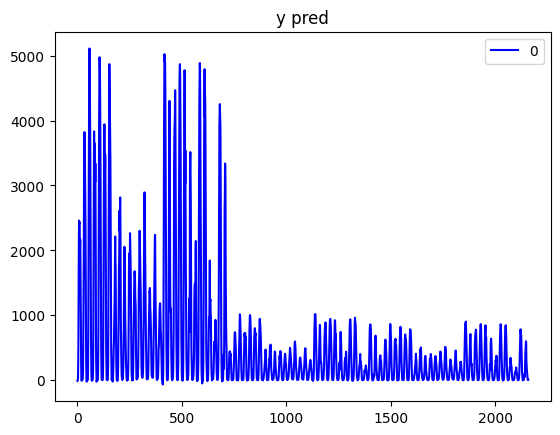

In [60]:

preds_df = pd.DataFrame(preds)


preds_df.plot(title='y pred', color='blue')


In [61]:

if save:
    model.save_model("models/" + model_name)
    pred_to_delivery(ReLU(preds),'Delivered_preds/' + model_name + '.csv')